***Vessel Segmentation (gray) for retina fundus images***

Credit: SA - UNet (github) [SA - UNet](https://github.com/clguo/SA-UNet)

This code requires an environment of tensorflow 2.0 version or above. The scipy==1.1.0 is recommended to avoid incompatible errors.

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras import backend as K

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, \
    Conv2D, Add, Activation, Lambda,Conv1D
from PIL import Image
import numpy as np
import glob
import os
import cv2
from keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
from  scipy.misc.pilutil import *
from keras.optimizers import *
from keras.models import Model
from keras.layers import Input,Conv2DTranspose, MaxPooling2D,BatchNormalization,concatenate,Activation


## **Data Preparation**

In [ ]:
data_path = '/content/drive/MyDrive/VascularSignaturesPreeclampsia/Datasets/DRIVE'

In [ ]:

image_number = []
image_list = []
for filename in glob.glob(data_path + 'training/images/*.tif'):
    num = filename.split('/')[-1].split('_')[0]
    im=Image.open(filename)
    image_number.append(num)
    #im.show()
    im = np.array(im)
    image_list.append(im)

label_number = []
label_list = []
for filename in glob.glob(data_path + '/training/1st_manual/*.gif'):
    num = filename.split('/')[-1].split('_')[0]
    im=Image.open(filename)
    label_number.append(num)
    #im.show()
    im = np.array(im)
    label_list.append(im)

In [ ]:
x = image_list
y = label_list

print('total # of images:', len(x))
print('total # of labels:', len(y))

total # of images: 68
total # of labels: 68


Resize and max normalization

In [ ]:
x_train = []
y_train = []
for i in range(len(x)):
    ratio_x = 1008 / x[i].shape[1]
    ratio_y = 1008 / x[i].shape[0]
    im_1008 = cv2.resize(x[i], (0, 0), fx=ratio_x, fy=ratio_y)
    x_train.append(im_1008)
    
    ratio_x = 1008 / y[i].shape[1]
    ratio_y = 1008 / y[i].shape[0]
    label_1008 = cv2.resize(y[i], (0, 0), fx=ratio_x, fy=ratio_y)
    y_train.append(label_1008)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = x_train / 255
y_train = y_train / 255

# **SA-UNet**

### Drop Block

In [ ]:

class DropBlock1D(keras.layers.Layer):
    """See: https://arxiv.org/pdf/1810.12890.pdf"""

    def __init__(self,
                 block_size,
                 keep_prob,
                 sync_channels=False,
                 data_format=None,
                 **kwargs):
        """Initialize the layer.
        :param block_size: Size for each mask block.
        :param keep_prob: Probability of keeping the original feature.
        :param sync_channels: Whether to use the same dropout for all channels.
        :param data_format: 'channels_first' or 'channels_last' (default).
        :param kwargs: Arguments for parent class.
        """
        super(DropBlock1D, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob
        self.sync_channels = sync_channels
        #self.data_format = K.normalize_data_format(data_format) keras.utils.conv_utils.normalize_data_format
        self.data_format = keras.utils.conv_utils.normalize_data_format(data_format) 
        self.input_spec = keras.engine.base_layer.InputSpec(ndim=3)
        self.supports_masking = True

    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob,
                  'sync_channels': self.sync_channels,
                  'data_format': self.data_format}
        base_config = super(DropBlock1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask=None):
        return mask

    def compute_output_shape(self, input_shape):
        return input_shape

    def _get_gamma(self, feature_dim):
        """Get the number of activation units to drop"""
        feature_dim = K.cast(feature_dim, K.floatx())
        block_size = K.constant(self.block_size, dtype=K.floatx())
        return ((1.0 - self.keep_prob) / block_size) * (feature_dim / (feature_dim - block_size + 1.0))

    def _compute_valid_seed_region(self, seq_length):
        positions = K.arange(seq_length)
        half_block_size = self.block_size // 2
        valid_seed_region = K.switch(
            K.all(
                K.stack(
                    [
                        positions >= half_block_size,
                        positions < seq_length - half_block_size,
                    ],
                    axis=-1,
                ),
                axis=-1,
            ),
            K.ones((seq_length,)),
            K.zeros((seq_length,)),
        )
        return K.expand_dims(K.expand_dims(valid_seed_region, axis=0), axis=-1)

    def _compute_drop_mask(self, shape):
        seq_length = shape[1]
        mask = K.random_binomial(shape, p=self._get_gamma(seq_length))
        mask *= self._compute_valid_seed_region(seq_length)
        mask = keras.layers.MaxPool1D(
            pool_size=self.block_size,
            padding='same',
            strides=1,
            data_format='channels_last',
        )(mask)
        return 1.0 - mask

    def call(self, inputs):

        def dropped_inputs():
            outputs = inputs
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 2, 1])
            shape = K.shape(outputs)
            if self.sync_channels:
                mask = self._compute_drop_mask([shape[0], shape[1], 1])
            else:
                mask = self._compute_drop_mask(shape)
            outputs = outputs * mask *\
                (K.cast(K.prod(shape), dtype=K.floatx()) / K.sum(mask))
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 2, 1])
            return outputs

        return K.in_train_phase(dropped_inputs, inputs)


class DropBlock2D(keras.layers.Layer):
    """See: https://arxiv.org/pdf/1810.12890.pdf"""

    def __init__(self,
                 block_size,
                 keep_prob,
                 sync_channels=False,
                 data_format=None,
                 **kwargs):
        """Initialize the layer.
        :param block_size: Size for each mask block.
        :param keep_prob: Probability of keeping the original feature.
        :param sync_channels: Whether to use the same dropout for all channels.
        :param data_format: 'channels_first' or 'channels_last' (default).
        :param kwargs: Arguments for parent class.
        """
        super(DropBlock2D, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob
        self.sync_channels = sync_channels
        self.data_format = keras.utils.conv_utils.normalize_data_format(data_format)
        self.input_spec = keras.engine.base_layer.InputSpec(ndim=4)
        self.supports_masking = True

    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob,
                  'sync_channels': self.sync_channels,
                  'data_format': self.data_format}
        base_config = super(DropBlock2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask=None):
        return mask

    def compute_output_shape(self, input_shape):
        return input_shape

    def _get_gamma(self, height, width):
        """Get the number of activation units to drop"""
        height, width = K.cast(height, K.floatx()), K.cast(width, K.floatx())
        block_size = K.constant(self.block_size, dtype=K.floatx())
        return ((1.0 - self.keep_prob) / (block_size ** 2)) *\
               (height * width / ((height - block_size + 1.0) * (width - block_size + 1.0)))

    def _compute_valid_seed_region(self, height, width):

        p1 = K.arange(height)
        p2 = K.arange(width)

        t1 = K.expand_dims(p1, axis=1)
        t2 = K.expand_dims(p2, axis=0)

        tp1 = K.tile(t1, [1, width])
        tp2 = K.tile(t2, [height, 1])

        temp1 = K.expand_dims(tp1, axis=-1)
        temp2 = K.expand_dims(tp2, axis=-1)
                              
        positions = K.concatenate([temp1, temp2], axis=-1)


        half_block_size = self.block_size // 2
        valid_seed_region = K.switch(
            K.all(
                K.stack(
                    [
                        positions[:, :, 0] >= half_block_size,
                        positions[:, :, 1] >= half_block_size,
                        positions[:, :, 0] < height - half_block_size,
                        positions[:, :, 1] < width - half_block_size,
                    ],
                    axis=-1,
                ),
                axis=-1,
            ),
            K.ones((height, width)),
            K.zeros((height, width)),
        )
        return K.expand_dims(K.expand_dims(valid_seed_region, axis=0), axis=-1)

    def _compute_drop_mask(self, shape):
        height, width = shape[1], shape[2]
        mask = K.random_binomial(shape, p=self._get_gamma(height, width))
        mask *= self._compute_valid_seed_region(height, width)
        mask = keras.layers.MaxPool2D(
            pool_size=(self.block_size, self.block_size),
            padding='same',
            strides=1,
            data_format='channels_last',
        )(mask)
        return 1.0 - mask

    def call(self, inputs, training = None):

        def dropped_inputs():
            outputs = inputs
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 2, 3, 1])
            shape = K.shape(outputs)
            if self.sync_channels:
                mask = self._compute_drop_mask([shape[0], shape[1], shape[2], 1])
            else:
                mask = self._compute_drop_mask(shape)
            outputs = outputs * mask *\
                (K.cast(K.prod(shape), dtype=K.floatx()) / K.sum(mask))
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 3, 1, 2])
            return outputs

        return K.in_train_phase(dropped_inputs, inputs, training=training)

## Spatial Attention

In [ ]:

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])


## Backbone

In [ ]:


def Backbone(input_size=(1440, 1440, 3), block_size=7,keep_prob=0.9,start_neurons=16,lr=1e-3):

    inputs = Input(input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv1)
    conv1= BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(conv1)
    conv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)



    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(conv2)
    conv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)


    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(conv3)
    conv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    convm = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(convm)
    convm = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])


    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)

    model = Model(input=inputs, output=output_layer)

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model
def SA_UNet(input_size=(512, 512, 3), block_size=7,keep_prob=0.9,start_neurons=16,lr=1e-3):

    inputs = Input(input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    #conv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv1)
    conv1= BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(conv1)
    #conv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)



    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    #conv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(conv2)
    #conv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)


    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    #conv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(conv3)
    #conv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    #convm = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    convm = spatial_attention(convm)
    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(convm)
    #convm = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    #uconv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    #uconv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    #uconv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    #uconv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])


    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    #uconv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    #uconv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)

    model = Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model


Train from Scratch

In [ ]:
data_location = '.../'

training_images_loc = data_location + 'training/training/images/'
training_label_loc = data_location + 'training/training/1st_manual/'

validate_images_loc = data_location + 'validation/validation/images/'
validate_label_loc = data_location + 'validation/validation/1st_manual/'
train_files = os.listdir(training_images_loc)
train_data = []
train_label = []
validate_files = os.listdir(validate_images_loc)
validate_data = []
validate_label = []
desired_size = 592
for i in train_files:
    im = imread(training_images_loc + i)
    label = imread(training_label_loc + i.split('_')[0] + '_manual1.gif',mode="L")
    old_size = im.shape[:2]  # old_size is in (height, width) format
    delta_w = desired_size - old_size[1]
    delta_h = desired_size - old_size[0]

    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    color2 = [0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                value=color)

    new_label = cv2.copyMakeBorder(label, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                   value=color2)

    train_data.append(cv2.resize(new_im, (desired_size, desired_size)))

    temp = cv2.resize(new_label, (desired_size, desired_size))
    _, temp = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)
    train_label.append(temp)

for i in validate_files:
    im = imread(validate_images_loc + i)
    label = imread(validate_label_loc + i.split('_')[0] + '_manual1.gif',mode="L")
    old_size = im.shape[:2]  # old_size is in (height, width) format
    delta_w = desired_size - old_size[1]
    delta_h = desired_size - old_size[0]

    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    color2 = [0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                value=color)

    new_label = cv2.copyMakeBorder(label, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                   value=color2)

    validate_data.append(cv2.resize(new_im, (desired_size, desired_size)))

    temp = cv2.resize(new_label, (desired_size, desired_size))
    _, temp = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)
    validate_label.append(temp)

train_data = np.array(train_data)
train_label = np.array(train_label)

validate_data = np.array(validate_data)
validate_label = np.array(validate_label)

x_train = train_data.astype('float32') / 255.
y_train = train_label.astype('float32') / 255.
x_train = np.reshape(x_train, (
len(x_train), desired_size, desired_size, 3))  # adapt this if using `channels_first` image data format
y_train = np.reshape(y_train, (len(y_train), desired_size, desired_size, 1))  # adapt this if using `channels_first` im

x_validate = validate_data.astype('float32') / 255.
y_validate = validate_label.astype('float32') / 255.
x_validate = np.reshape(x_validate, (
len(x_validate), desired_size, desired_size, 3))  # adapt this if using `channels_first` image data format
y_validate = np.reshape(y_validate,
                        (len(y_validate), desired_size, desired_size, 1))  # adapt this if using `channels_first` im

TensorBoard(log_dir='./autoencoder', histogram_freq=0,
            write_graph=True, write_images=True)


Fine-tune pretrained models

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 592, 592, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_192 (Conv2D)            (None, 592, 592, 16  448         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_168 (Batch  (None, 592, 592, 16  64         ['conv2d_192[0][0]']             
 Normalization)                 )                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 conv2d_202 (Conv2D)            (None, 148, 148, 64  36928       ['activation_188[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_177 (Batch  (None, 148, 148, 64  256        ['conv2d_202[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 activation_189 (Activation)    (None, 148, 148, 64  0           ['batch_normalization_177[0][0]']
                                )                                                                 
                                                                                                  
 conv2d_transpose_37 (Conv2DTra  (None, 296, 296, 32  18464      ['activation_189[0][0]']         
 nspose)  

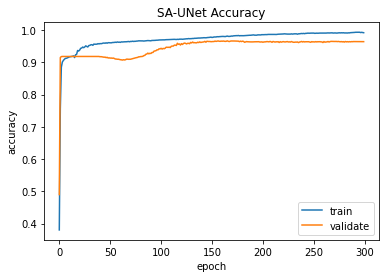

In [ ]:

model=SA_UNet(input_size=(desired_size,desired_size,3),start_neurons=16,lr=1e-3,keep_prob=0.82,block_size=7)
model.summary()
weight='/pretrained_weights/SA_UNet.h5'
restore= False

if restore and os.path.isfile(weight):
    model.load_weights(weight)
    print('loaded a pretrained model')

model_checkpoint = ModelCheckpoint(weight, monitor='val_accuracy', verbose=1, save_best_only=True)


history=model.fit(x_train, y_train,
                epochs=300, #first  100 with lr=1e-3,,and last 50 with lr=1e-4
                batch_size=4,
                # validation_split=0.05,

                validation_data=(x_validate, y_validate),
                shuffle=True,
                callbacks= [TensorBoard(log_dir='./autoencoder'), model_checkpoint])

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('SA-UNet Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')
plt.show()


model.load_weights('/content/drive/MyDrive/VascularSignaturesPreeclampsia/Codes/SA_UNet.h5')

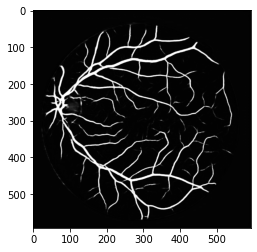

In [ ]:
pred = model.predict(x_validate)
plt.imshow(pred[0][:,:,0], cmap = 'gray')